In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import yfinance as yf
import datetime

In [3]:
ticker = ["IDEA.NS"]

In [4]:
vi_stocks = yf.download(ticker, start = "2016-01-01", end = "2020-12-04")

[*********************100%***********************]  1 of 1 completed


In [5]:
vi_stocks.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,86.194397,87.098900,85.742203,86.345200,85.327797,1686813
2016-01-04,85.169403,85.862801,81.189796,81.762604,80.799194,4585633
2016-01-05,82.154503,83.209702,81.069199,81.611900,80.650269,3219017
2016-01-06,81.702301,83.209702,80.677299,81.099297,80.143700,6293905
2016-01-07,80.586800,81.551598,79.019096,80.436096,79.488319,5184476


In [6]:
vi_stocks.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-11-26,9.70,10.00,9.60,9.95,9.95,273322035
2020-11-27,10.00,10.10,9.65,9.80,9.80,211191365
2020-12-01,9.80,10.35,9.60,10.00,10.00,354320484
2020-12-02,9.95,10.20,9.80,9.90,9.90,172606976
2020-12-03,10.00,10.05,9.80,9.95,9.95,151257328


In [7]:
vi_stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1213 entries, 2016-01-01 to 2020-12-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1213 non-null   float64
 1   High       1213 non-null   float64
 2   Low        1213 non-null   float64
 3   Close      1213 non-null   float64
 4   Adj Close  1213 non-null   float64
 5   Volume     1213 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 66.3 KB


In [8]:
vi_stocks.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1213.000000,1213.000000,1213.000000,1213.000000,1213.000000,1.213000e+03
mean,34.241079,34.933263,33.448977,34.124159,34.013319,1.135101e+08
std,22.681052,23.039450,22.301898,22.630716,22.481730,1.885403e+08
min,2.700000,3.150000,2.400000,2.950000,2.950000,5.348700e+05
25%,10.100000,10.450000,9.650000,10.050000,10.050000,1.344610e+07
50%,34.972198,35.846500,33.464802,34.308899,34.308899,3.111071e+07
75%,53.664200,55.081200,52.759800,53.634102,53.634102,1.211253e+08
max,86.194397,87.098900,85.742203,86.345200,85.327797,1.073742e+09


In [9]:
vi_close = vi_stocks.reset_index()['Close']
vi_close

0       86.345200
1       81.762604
2       81.611900
3       81.099297
4       80.436096
          ...    
1208     9.950000
1209     9.800000
1210    10.000000
1211     9.900000
1212     9.950000
Name: Close, Length: 1213, dtype: float64

In [10]:
vi_close.shape

(1213,)

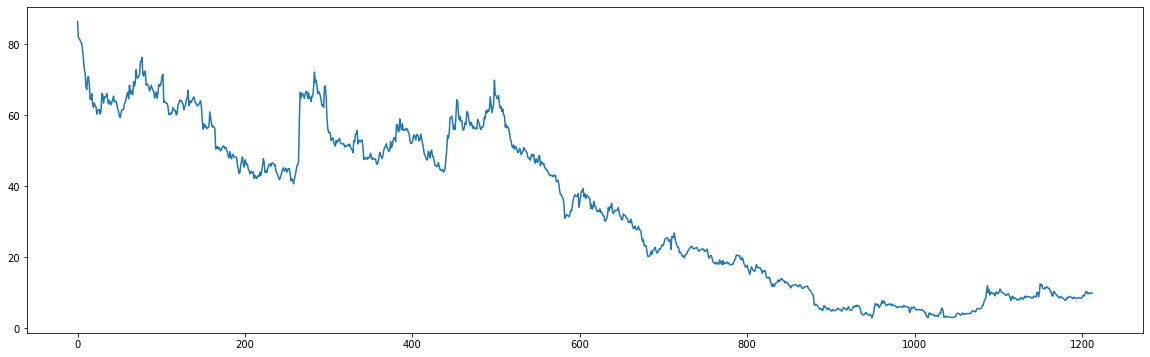

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize = [20,6])
plt.plot(vi_close)

### LSTM Model

In [12]:
import numpy as np

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
vi_close = scaler.fit_transform(np.array(vi_close).reshape(-1,1))

In [14]:
vi_close.shape

(1213, 1)

### Splitting Data into train and test dataset

In [15]:
training_size = int(len(vi_close)*0.65)
train_data, test_data = vi_close[:training_size,:], vi_close[training_size:,:]

In [16]:
vi_close

array([[1.        ],
       [0.94504964],
       [0.94324255],
       ...,
       [0.08453724],
       [0.08333813],
       [0.08393768]])

In [17]:
train_data.shape

(788, 1)

In [18]:
test_data.shape

(425, 1)

### Data Preprocessing

In [19]:
def create_dataset(dataset, timestamp = 1):
    import numpy as np
    dataX, dataY = [], []
    for i in range(len(dataset) - timestamp -1):
        a = dataset[i:(i+timestamp),0]
        dataX.append(a)
        dataY.append(dataset[i+timestamp,0])
    return np.array(dataX), np.array(dataY)

In [20]:
timestamp = 100
X_train, y_train = create_dataset(train_data, timestamp)
X_test, y_test = create_dataset(test_data, timestamp)

In [21]:
X_test.shape

(324, 100)

In [22]:
y_test.shape

(324,)

### Converting into 3 dimensional matrix for stacked LSTM Model

In [23]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

### Importing tensorflow libraries

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
model = Sequential()
model.add(LSTM(50, return_sequences =True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, verbose =2)

Train on 687 samples, validate on 324 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
687/687 - 5s - loss: 0.1154 - val_loss: 0.0263
Epoch 2/50
687/687 - 2s - loss: 0.0149 - val_loss: 0.0180
Epoch 3/50
687/687 - 2s - loss: 0.0072 - val_loss: 0.0204
Epoch 4/50
687/687 - 3s - loss: 0.0054 - val_loss: 0.0189
Epoch 5/50
687/687 - 4s - loss: 0.0045 - val_loss: 0.0124
Epoch 6/50
687/687 - 4s - loss: 0.0037 - val_loss: 0.0089
Epoch 7/50
687/687 - 4s - loss: 0.0031 - val_loss: 0.0053
Epoch 8/50
687/687 - 4s - loss: 0.0028 - val_loss: 0.0031
Epoch 9/50
687/687 - 4s - loss: 0.0027 - val_loss: 0.0021
Epoch 10/50
687/687 - 4s - loss: 0.0026 - val_loss: 0.0016
Epoch 11/50
687/687 - 4s - loss: 0.0026 - val_loss: 0.0015
Epoch 12/50
687/687 - 2s - loss: 0.0026 - val_loss: 0.0014
Epoch 13/50
687/687 - 2s - loss: 0.0025 - val_loss: 0.0013
Epoch 14/50
687/687 - 3s - loss: 0.0024 - val_loss: 0.0013
Epoch 15/50
687/687 - 4s - loss: 0.0024 - v

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [ ]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(y_train, train_predict))

In [ ]:
np.sqrt(mean_squared_error(y_test, test_predict))

In [ ]:
lookback = timestamp
# shift trainpredictions for plotting
trainPredictPlot = np.empty_like(vi_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[lookback:len(train_predict)+lookback, :] = train_predict

# shift test predictions for plotting 
testPredictPlot = np.empty_like(vi_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(lookback*2)+1:len(vi_close)-1, :] = test_predict

# plot baseline and predictions
plt.figure(figsize = [20,6])
plt.plot(scaler.inverse_transform(vi_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
X_input = test_data[len(test_data)-timestamp:].reshape(1,-1)
X_input.shape

In [ ]:
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

In [ ]:
from numpy import array
lst_output = []
n_steps = timestamp
i=0
while(i<30):
    if len(temp_input)>100:
        X_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, X_input))
        X_input = X_input.reshape(1,-1)
        X_input =X_input.reshape((1, n_steps, 1))
        
        y_hat = model.predict(X_input, verbose = 0)
        print("{} day output {}".format(i, y_hat))
        temp_input.extend(y_hat[0].tolist())
        temp_input = temp_input[1:]
        
        lst_output.extend(y_hat.tolist())
        i = i+1
        
    else:
        X_input = X_input.reshape((1, n_steps, 1))
        y_hat = model.predict(X_input, verbose = 0)
        print(y_hat[0])
        temp_input.extend(y_hat[0].tolist())
        print(len(temp_input))
        i = i+1

In [ ]:
day_new = np.arange(1,101)
day_pred = np.arange(101,130)

In [ ]:
vi_close_1 = vi_close.tolist()
vi_close_1.extend(lst_output)

In [ ]:
plt.plot(day_new, scaler.inverse_transform(vi_close[1113:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))

In [ ]:
future_forecast = scaler.inverse_transform(lst_output)
len(future_forecast)

In [ ]:
start = datetime.datetime(2020,12,5)
end = datetime.datetime(2021,1,15)
forecast = pd.DataFrame(pd.bdate_range(start, end), columns = ['Date'])

In [ ]:
forecast = forecast.loc[:28]
forecast['Idea NSE Closing Price'] = future_forecast

In [ ]:
forecast